# **Using Association Rules for Safety Data**
Adam McKinnon and I decided to explore the use of association rules to help prevent safety incidents. Workplace safety datasets are not readily available, so we’ve decided to use a dataset of UK vehicle incidents to demonstrate how this analysis could be done.

Adam and I use different languages (I use Python and he uses R), so we wanted to leverage the strengths of each. As such, I used Python for all data exploration and prep, and to run the apriori algorithm (code included in this notebook). Adam then used R to create the visualizations. 

An article will be published soon that includes those visualizations, as well as the code. 

## **Table of Contents**

* [Introduction & Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results](#results)
* [Conclusion](#conclusion)

(This project was a collaboration between myself and Adam McKinnon.)

### **Introduction & Business Problem** <a name="introduction"></a>

**Introduction**

Tell me what I need to know! The quintessential challenge for any data professional. Take the endeavour you have invested your time in for the last weeks or months and boil it down to a few key takeaways for a business leader. Forget your methods… I’m not interested in your sexy Machine Learning models! Forget your data caveats… I don’t care about the nuances! Don’t bore me with your understanding of the context… I’m leading the business, I know it better than you! JUST TELL ME WHAT I NEED TO KNOW!!!

In this project, we explore the use of Association Rules in the context of Safety. We test whether: 

Association Rules can assist in the synthesis of large amounts of safety data to identify intervention points to prevent future incidents (i.e., tell me what I need to know); and New ways of visualising Association Rule outputs to make interpretation, and more importantly, use of the findings easier in a safety context (i.e., you’ve visualised your synthesis in a way that leaves nothing to doubt).

**Business Challenge**

A large manufacturing company is committed to providing the safest working conditions for their employees. There are many initiatives to track and prevent injuries across their facilities, but safety incidents are still happening more frequently than they’d like. They capture very detailed data for each incident and at a recent meeting, the VP of Manufacturing asked HR if they can analyse the safety data to determine whether there are conditions commonly associated with incidents, which if addressed, could prevent future incidents. HR turned to their HR Analytics team to analyse the safety data and identify preventable conditions.


### **Data** <a name="data"></a>

We used the UK Road Safety Data ([available on the Kaggle website](https://www.kaggle.com/tsiaras/uk-road-safety-accidents-and-vehicles)). There are two data sets, accident information and vehicle information. Both sets are quite large, so we focussed the analysis on 2015 data only before we merged the two datasets to combine accident and vehicle conditions.

Using the Apriori Algorithm to find associations between different accident conditions requires categorical data, so we prepared and binned some of the data before we ran the analyses. 

Finally, we focussed on the variables that represented pre-accident conditions. These variables were then one-hot encoded, a method that allows analysts to identify which conditions were and were not present during each incident (represented as a ‘1’ and ‘0’ respectively).  

#####*Importing libraries*
Before we get started, we need to import the necessary libraries for our analysis. I've commented out the libraries I already have installed on my computer. 

In [ ]:
#mount to google drive for data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt 
! %matplotlib inline
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

/bin/bash: line 0: fg: no job control


In [ ]:
import plotly.graph_objects as go

##### *Accident Information data*

In [ ]:
#Create dataframe using csv file shared in my G Drive
df=pd.read_csv('/content/drive/MyDrive/Kaggle/Accident_Information.csv',low_memory=False) #set low_memory to false due to size of data
df.shape #check the shape of the dataframe

(2047256, 34)

In [ ]:
#Create a new dataframe with only 2015 data
accident_data = df[df['Year'] == 2015]
print(accident_data.shape) #check the shape of the dataframe
accident_data.head()

(140056, 34)


,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Control,Junction_Detail,Latitude,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Location_Easting_OSGR,Location_Northing_OSGR,Longitude,LSOA_of_Accident_Location,Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year,InScotland
1640597,201501BS70001,C,0.0,Unclassified,0.0,Slight,None,2015-01-12,Monday,1.0,Give way or uncontrolled,T or staggered junction,51.505538,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,525130.0,180050.0,-0.198465,E01002825,1,1,0.0,0.0,Metropolitan Police,Dry,Single carriageway,None,30.0,18:45,Urban,Fine no high winds,2015,No
1640598,201501BS70002,Unclassified,0.0,A,3218.0,Slight,None,2015-01-12,Monday,1.0,Give way or uncontrolled,T or staggered junction,51.491836,Daylight,Kensington and Chelsea,Kensington and Chelsea,526530.0,178560.0,-0.178838,E01002820,1,1,0.0,0.0,Metropolitan Police,Dry,Single carriageway,None,30.0,07:50,Urban,Fine no high winds,2015,No
1640599,201501BS70004,B,415.0,Unclassified,0.0,Slight,None,2015-01-12,Monday,1.0,Give way or uncontrolled,Mini-roundabout,51.514910,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,524610.0,181080.0,-0.205590,E01002833,1,1,0.0,1.0,Metropolitan Police,Wet or damp,Single carriageway,None,30.0,18:08,Urban,Raining no high winds,2015,No
1640600,201501BS70005,B,450.0,Unclassified,0.0,Slight,None,2015-01-13,Tuesday,2.0,Give way or uncontrolled,Crossroads,51.514952,Daylight,Kensington and Chelsea,Kensington and Chelsea,524420.0,181080.0,-0.208327,E01002874,1,1,0.0,0.0,Metropolitan Police,Wet or damp,Single carriageway,None,30.0,07:40,Urban,Fine no high winds,2015,No
1640601,201501BS70008,A,315.0,A,3220.0,Serious,None,2015-01-09,Friday,2.0,Auto traffic signal,Crossroads,51.496572,Daylight,Kensington and Chelsea,Kensington and Chelsea,524630.0,179040.0,-0.206022,E01002814,1,2,0.0,5.0,Metropolitan Police,Wet or damp,Single carriageway,None,30.0,07:30,Urban,Raining no high winds,2015,No


In [ ]:
#Reset the index and drop new column that is created with old index
accident_data = accident_data.reset_index()
accident_data.drop(['index'], axis=1, inplace=True)
print(accident_data.shape) #check shape to make sure nothing has changed 
accident_data.head()

(140056, 34)


,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Control,Junction_Detail,Latitude,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Location_Easting_OSGR,Location_Northing_OSGR,Longitude,LSOA_of_Accident_Location,Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year,InScotland
0,201501BS70001,C,0.0,Unclassified,0.0,Slight,None,2015-01-12,Monday,1.0,Give way or uncontrolled,T or staggered junction,51.505538,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,525130.0,180050.0,-0.198465,E01002825,1,1,0.0,0.0,Metropolitan Police,Dry,Single carriageway,None,30.0,18:45,Urban,Fine no high winds,2015,No
1,201501BS70002,Unclassified,0.0,A,3218.0,Slight,None,2015-01-12,Monday,1.0,Give way or uncontrolled,T or staggered junction,51.491836,Daylight,Kensington and Chelsea,Kensington and Chelsea,526530.0,178560.0,-0.178838,E01002820,1,1,0.0,0.0,Metropolitan Police,Dry,Single carriageway,None,30.0,07:50,Urban,Fine no high winds,2015,No
2,201501BS70004,B,415.0,Unclassified,0.0,Slight,None,2015-01-12,Monday,1.0,Give way or uncontrolled,Mini-roundabout,51.514910,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,524610.0,181080.0,-0.205590,E01002833,1,1,0.0,1.0,Metropolitan Police,Wet or damp,Single carriageway,None,30.0,18:08,Urban,Raining no high winds,2015,No
3,201501BS70005,B,450.0,Unclassified,0.0,Slight,None,2015-01-13,Tuesday,2.0,Give way or uncontrolled,Crossroads,51.514952,Daylight,Kensington and Chelsea,Kensington and Chelsea,524420.0,181080.0,-0.208327,E01002874,1,1,0.0,0.0,Metropolitan Police,Wet or damp,Single carriageway,None,30.0,07:40,Urban,Fine no high winds,2015,No
4,201501BS70008,A,315.0,A,3220.0,Serious,None,2015-01-09,Friday,2.0,Auto traffic signal,Crossroads,51.496572,Daylight,Kensington and Chelsea,Kensington and Chelsea,524630.0,179040.0,-0.206022,E01002814,1,2,0.0,5.0,Metropolitan Police,Wet or damp,Single carriageway,None,30.0,07:30,Urban,Raining no high winds,2015,No


Now that we have our data for 2015, we will remove columns that we do not want to include in our analysis because those features are not contributing conditions for the accident and/or there will not be anything actionable if associations are found for those features. 

In [ ]:
#drop the unused columns 
accident_data.drop(['1st_Road_Number', '2nd_Road_Number', 'Did_Police_Officer_Attend_Scene_of_Accident', 'Latitude', 'Location_Easting_OSGR','Location_Northing_OSGR',\
                    'Longitude', 'LSOA_of_Accident_Location', 'Pedestrian_Crossing-Human_Control', 'Special_Conditions_at_Site', 'Year', 'InScotland'], axis=1, inplace=True)
print(accident_data.shape)
accident_data.head()

(140056, 22)


,Accident_Index,1st_Road_Class,2nd_Road_Class,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Junction_Control,Junction_Detail,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions
0,201501BS70001,C,Unclassified,Slight,None,2015-01-12,Monday,Give way or uncontrolled,T or staggered junction,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,1,1,0.0,Metropolitan Police,Dry,Single carriageway,30.0,18:45,Urban,Fine no high winds
1,201501BS70002,Unclassified,A,Slight,None,2015-01-12,Monday,Give way or uncontrolled,T or staggered junction,Daylight,Kensington and Chelsea,Kensington and Chelsea,1,1,0.0,Metropolitan Police,Dry,Single carriageway,30.0,07:50,Urban,Fine no high winds
2,201501BS70004,B,Unclassified,Slight,None,2015-01-12,Monday,Give way or uncontrolled,Mini-roundabout,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,1,1,1.0,Metropolitan Police,Wet or damp,Single carriageway,30.0,18:08,Urban,Raining no high winds
3,201501BS70005,B,Unclassified,Slight,None,2015-01-13,Tuesday,Give way or uncontrolled,Crossroads,Daylight,Kensington and Chelsea,Kensington and Chelsea,1,1,0.0,Metropolitan Police,Wet or damp,Single carriageway,30.0,07:40,Urban,Fine no high winds
4,201501BS70008,A,A,Serious,None,2015-01-09,Friday,Auto traffic signal,Crossroads,Daylight,Kensington and Chelsea,Kensington and Chelsea,1,2,5.0,Metropolitan Police,Wet or damp,Single carriageway,30.0,07:30,Urban,Raining no high winds


##### *Vehicle Information data*

In [ ]:
#Create dataframe using csv file shared in my G Drive
#set low_memory to false due to size of data; encoding addresses characters that flag errors when converting to a dataframe
df2=pd.read_csv('/content/drive/MyDrive/Kaggle/Vehicle_Information.csv', low_memory=False, encoding='windows-1252') 
print(df2.shape) #check the shape of the dataframe

(2177205, 24)


In [ ]:
#create a new dataframe with only 2015 data
vehicle_data = df2[df2['Year'] == 2015]
print(vehicle_data.shape) #check the shape of the dataframe
vehicle_data.head()

(257845, 24)


,Accident_Index,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,Junction_Location,make,model,Propulsion_Code,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Location.Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Year
1666860,201501BS70001,Data missing or out of range,4.0,Data missing or out of range,NaN,2143.0,None,None,Journey as part of work,Mid Junction - on roundabout or on main road,MERCEDES,SPRINTER 310 CDI,Heavy oil,Male,None,No tow/articulation,Did not leave carriageway,0.0,Turning right,1,Van / Goods 3.5 tonnes mgw or under,No,Front,2015
1666861,201501BS70002,Data missing or out of range,3.0,Data missing or out of range,NaN,1600.0,None,None,Not known,Mid Junction - on roundabout or on main road,BMW,118I SE TURBO AUTO,Petrol,Male,None,No tow/articulation,Did not leave carriageway,0.0,Turning right,1,Car,No,Front,2015
1666862,201501BS70004,26 - 35,10.0,Urban area,NaN,1686.0,None,None,Not known,Cleared junction or waiting/parked at junction...,VAUXHALL,ASTRA CLUB CDTI,Heavy oil,Male,None,No tow/articulation,Did not leave carriageway,0.0,Turning right,1,Car,No,Front,2015
1666863,201501BS70005,Data missing or out of range,NaN,Data missing or out of range,NaN,NaN,None,None,Not known,Cleared junction or waiting/parked at junction...,NaN,NaN,NaN,Male,None,No tow/articulation,Did not leave carriageway,0.0,Turning right,1,Car,No,Front,2015
1666864,201501BS70008,46 - 55,NaN,Urban area,NaN,NaN,None,None,Commuting to/from work,Mid Junction - on roundabout or on main road,NaN,NaN,NaN,Male,None,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,Pedal cycle,No,Did not impact,2015


In [ ]:
#Reset the index and drop new column that is created with old index
vehicle_data = vehicle_data.reset_index()
vehicle_data.drop(['index'], axis=1, inplace=True)
print(vehicle_data.shape) #check shape to make sure nothing has changed 
vehicle_data.head()

(257845, 24)


,Accident_Index,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,Junction_Location,make,model,Propulsion_Code,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Location.Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Year
0,201501BS70001,Data missing or out of range,4.0,Data missing or out of range,NaN,2143.0,None,None,Journey as part of work,Mid Junction - on roundabout or on main road,MERCEDES,SPRINTER 310 CDI,Heavy oil,Male,None,No tow/articulation,Did not leave carriageway,0.0,Turning right,1,Van / Goods 3.5 tonnes mgw or under,No,Front,2015
1,201501BS70002,Data missing or out of range,3.0,Data missing or out of range,NaN,1600.0,None,None,Not known,Mid Junction - on roundabout or on main road,BMW,118I SE TURBO AUTO,Petrol,Male,None,No tow/articulation,Did not leave carriageway,0.0,Turning right,1,Car,No,Front,2015
2,201501BS70004,26 - 35,10.0,Urban area,NaN,1686.0,None,None,Not known,Cleared junction or waiting/parked at junction...,VAUXHALL,ASTRA CLUB CDTI,Heavy oil,Male,None,No tow/articulation,Did not leave carriageway,0.0,Turning right,1,Car,No,Front,2015
3,201501BS70005,Data missing or out of range,NaN,Data missing or out of range,NaN,NaN,None,None,Not known,Cleared junction or waiting/parked at junction...,NaN,NaN,NaN,Male,None,No tow/articulation,Did not leave carriageway,0.0,Turning right,1,Car,No,Front,2015
4,201501BS70008,46 - 55,NaN,Urban area,NaN,NaN,None,None,Commuting to/from work,Mid Junction - on roundabout or on main road,NaN,NaN,NaN,Male,None,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,Pedal cycle,No,Did not impact,2015


Just as we did with the accident data, we will remove columns that we do not want to include in our analysis because those features are not contributing conditions for the accident and/or there will not be anything actionable if associations are found for those features. 

In [ ]:
#drop the unused columns
vehicle_data.drop(['Junction_Location', 'model', 'Vehicle_Location.Restricted_Lane', 'Year'], axis=1, inplace=True)
print(vehicle_data.shape)
vehicle_data.head()

(257845, 20)


,Accident_Index,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,make,Propulsion_Code,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact
0,201501BS70001,Data missing or out of range,4.0,Data missing or out of range,NaN,2143.0,None,None,Journey as part of work,MERCEDES,Heavy oil,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Van / Goods 3.5 tonnes mgw or under,No,Front
1,201501BS70002,Data missing or out of range,3.0,Data missing or out of range,NaN,1600.0,None,None,Not known,BMW,Petrol,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Car,No,Front
2,201501BS70004,26 - 35,10.0,Urban area,NaN,1686.0,None,None,Not known,VAUXHALL,Heavy oil,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Car,No,Front
3,201501BS70005,Data missing or out of range,NaN,Data missing or out of range,NaN,NaN,None,None,Not known,NaN,NaN,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Car,No,Front
4,201501BS70008,46 - 55,NaN,Urban area,NaN,NaN,None,None,Commuting to/from work,NaN,NaN,Male,None,No tow/articulation,Did not leave carriageway,Going ahead other,1,Pedal cycle,No,Did not impact


##### *Merge the two datasets*

Now that both datasets are narrowed down to 2015 only and we've removed the columns we do not want to include in our analysis, it is now time to combine the tables before we begin the analysis. 

In [ ]:
#merge two dataframes using the 'Accident_Index' column
merged = pd.merge(accident_data, vehicle_data, how='inner', on=['Accident_Index', 'Accident_Index'])
#check the shape to make sure there are 41 columns
print(merged.shape)
#preview the new, merged dataframe
merged.head()

(257845, 41)


,Accident_Index,1st_Road_Class,2nd_Road_Class,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Junction_Control,Junction_Detail,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,make,Propulsion_Code,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact
0,201501BS70001,C,Unclassified,Slight,None,2015-01-12,Monday,Give way or uncontrolled,T or staggered junction,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,1,1,0.0,Metropolitan Police,Dry,Single carriageway,30.0,18:45,Urban,Fine no high winds,Data missing or out of range,4.0,Data missing or out of range,NaN,2143.0,None,None,Journey as part of work,MERCEDES,Heavy oil,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Van / Goods 3.5 tonnes mgw or under,No,Front
1,201501BS70002,Unclassified,A,Slight,None,2015-01-12,Monday,Give way or uncontrolled,T or staggered junction,Daylight,Kensington and Chelsea,Kensington and Chelsea,1,1,0.0,Metropolitan Police,Dry,Single carriageway,30.0,07:50,Urban,Fine no high winds,Data missing or out of range,3.0,Data missing or out of range,NaN,1600.0,None,None,Not known,BMW,Petrol,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Car,No,Front
2,201501BS70004,B,Unclassified,Slight,None,2015-01-12,Monday,Give way or uncontrolled,Mini-roundabout,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,1,1,1.0,Metropolitan Police,Wet or damp,Single carriageway,30.0,18:08,Urban,Raining no high winds,26 - 35,10.0,Urban area,NaN,1686.0,None,None,Not known,VAUXHALL,Heavy oil,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Car,No,Front
3,201501BS70005,B,Unclassified,Slight,None,2015-01-13,Tuesday,Give way or uncontrolled,Crossroads,Daylight,Kensington and Chelsea,Kensington and Chelsea,1,1,0.0,Metropolitan Police,Wet or damp,Single carriageway,30.0,07:40,Urban,Fine no high winds,Data missing or out of range,NaN,Data missing or out of range,NaN,NaN,None,None,Not known,NaN,NaN,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Car,No,Front
4,201501BS70008,A,A,Serious,None,2015-01-09,Friday,Auto traffic signal,Crossroads,Daylight,Kensington and Chelsea,Kensington and Chelsea,1,2,5.0,Metropolitan Police,Wet or damp,Single carriageway,30.0,07:30,Urban,Raining no high winds,46 - 55,NaN,Urban area,NaN,NaN,None,None,Commuting to/from work,NaN,NaN,Male,None,No tow/articulation,Did not leave carriageway,Going ahead other,1,Pedal cycle,No,Did not impact


In [ ]:
#save merged dataframe to google drive
merged.to_csv('/content/drive/MyDrive/Data Science/Association project/merged.csv', index=True)

### **Methodology** <a name="methodology"></a>

**Why Association Rules**

There are multiple approaches you could use to identify conditions associated with safety incidents. However, Association Rules provide a means of rapidly identifying conditions that frequently occur together–a key priority for safety and incident prevention.

**Overview of the key components of Association Rules** 

*Support:* Support represents the probability of two conditions appearing together (i.e., number of incidents containing both Condition A and Condition B relative to the size of the dataset). 

    Support = Probability of Condition A and Condition B happening

*Confidence:* Confidence represents the probability of Condition B happening given Condition A happened. 

    Confidence = Probability of Condition A and Condition B divided by the probability of Condition A 

*Lift:* Lift represents how certain we are that we can predict Condition B will happen if Condition A happens. It is generally agreed that a lift value greater than 1 reflects stronger associations.

    Lift = Probability of Condition B given Condition A divided by the probability of Condition B

**Approach**

*Exploratory analysis of the data*: Descriptive statistics was used to explore the data to uncover any patterns/findings that should be considered before or in conjunction with running the association rules.  

*Data preparation*: The apriori algorithm requires the use of categorical values, thus some data transformation is required. The exploratory analysis work allowed us identify ways to bin some variables. All others were further explored and transformed as needed. 

*Run the apriori algorithm*: Our goal was to synthesise the large safety dataset to rapidly identify the pre-incident conditions (known as antecedents in Association Rules) that often result in different incident severity outcomes (known as the consequents). Therefore, we decided to run the analysis three times, once for each accident severity (i.e., slight, serious, and fatal). Our rationale was twofold: 

*   The different incident severity outcomes occurred at different rates and thus needed different Support and consequent parameters applied to identify preventable conditions, and
*   To potentially enable prioritisation of results obtained from the analyses.

*Visualise the output*: Though the visualisations were done by Adam and are not reflected in this notebook, we used Python to prepare the data for visualisation by separating out the rules. 


### **Analysis** <a name="analysis"></a>

#####*Exploratory analysis of the  Data*
Previously, we narrowed the data to 2015, removed columns which we knew we didn't want to include in our analysis, and merged the two datsets. We will now run and review some descriptive statistics to explore the data. 

First, we will want to separate our analysis by accident severity, enabling prioritization of any actions to be taken following the analysis. Let's see how many accidents there were within each category. 

In [ ]:
#count distinct values for accident severity
merged['Accident_Severity'].value_counts()

Slight     220741
Serious     34205
Fatal        2899
Name: Accident_Severity, dtype: int64

As one would expect, the number of accidents decreases with severity. 

Now let's count accidents by day of week to see if there are any patterns there. 

Male                            169251
Female                           72046
Not known                        16529
Data missing or out of range        19
Name: Sex_of_Driver, dtype: int64


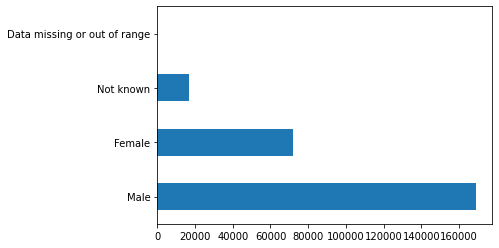

In [ ]:
#count distinct values for sex of driver and visualize in a bar graph
print(merged['Sex_of_Driver'].value_counts())
merged.Sex_of_Driver.value_counts().plot(kind = 'barh')

Friday       41565
Thursday     39815
Tuesday      39747
Wednesday    39736
Monday       37026
Saturday     32571
Sunday       27385
Name: Day_of_Week, dtype: int64


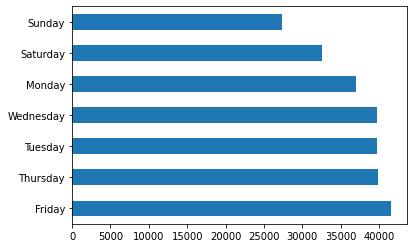

In [ ]:
#count distinct values for day of week and visualize in a bar graph
print(merged['Day_of_Week'].value_counts())
merged.Day_of_Week.value_counts().plot(kind = 'barh')

Friday has the most accidents, though not by many. Now let's see what the distribution looks like for day of the week when it comes to accident severity. 

Accident_Severity  Fatal  Serious  Slight
Day_of_Week                              
Friday               405     5472   35688
Monday               366     4598   32062
Saturday             464     4742   27365
Sunday               472     4240   22673
Thursday             392     4937   34486
Tuesday              376     5047   34324
Wednesday            424     5169   34143


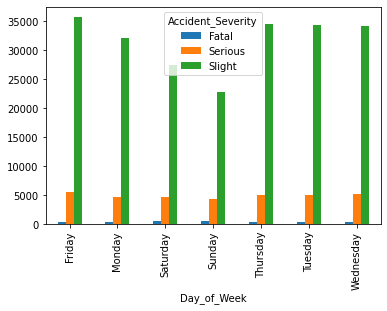

In [ ]:
#plot accident severity against day of week
#cross tabulation between 'Day_of_Week' and 'Accident_Severity'
CrosstabResult=pd.crosstab(index=merged['Day_of_Week'],columns=merged['Accident_Severity'])
print(CrosstabResult)
 
#grouped bar chart between 'Day_of_Week' and 'Accident_Severity'
CrosstabResult.plot.bar()

There are more fatal accidents on Saturday and Sunday, though the difference is not that great compared to ther days of the week. The rest of the distribution is in line with the overall distribution. 

Now let's explore the data by month. 

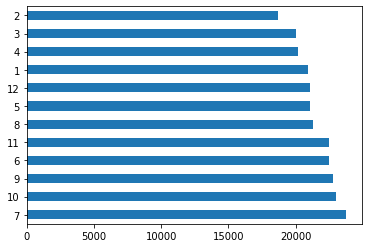

In [ ]:
#extract month from 'Date' column
merged['Month'] = pd.DatetimeIndex(merged['Date']).month

#count distinct values for month and visualize in a bar graph
merged.Month.value_counts().plot(kind = 'barh')

The most accidents happen in July, which is a summer month. It's also interesting to see that the fewest accidents are in the first 4 months of the year. Now let's again look at the distribution by accident severity. 

Accident_Severity  Fatal  Serious  Slight
Month                                    
1                    230     2469   18246
2                    229     2338   16132
3                    181     2491   17392
4                    238     2670   17259
5                    248     3008   17853
6                    254     3044   19219
7                    278     3162   20300
8                    264     3116   17899
9                    215     3021   19556
10                   255     3118   19625
11                   229     2945   19300
12                   278     2823   17960


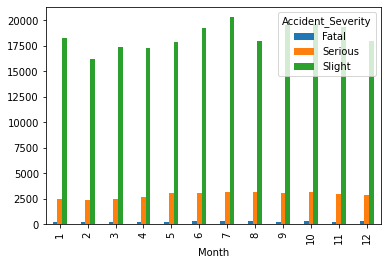

In [ ]:
#plot accident severity against day of week
#cross tabulation between 'Month' and 'Accident_Severity'
CrosstabResult=pd.crosstab(index=merged['Month'],columns=merged['Accident_Severity'])
print(CrosstabResult)
 
#grouped bar chart between 'Month' and 'Accident_Severity'
CrosstabResult.plot.bar()

The distriution of accident severity by month is in line with the distribution of accidents overall by month. 

Finally, lets look at the data by time of day by grouping the time into 6 buckets.

In [ ]:
#convert time to integer
merged['Hour'] = pd.to_datetime(merged['Time']).dt.hour

#bin time into time of day
merged['Time_of_Day'] = pd.cut(merged['Hour'], 
                    bins=[0,5,12,17,24], 
                    include_lowest=True, 
                    labels=['Early Morning','Morning','Afternoon','Evening'])
merged.head()

,Accident_Index,1st_Road_Class,2nd_Road_Class,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Junction_Control,Junction_Detail,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,make,Propulsion_Code,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Month,Hour,Time_of_Day
0,201501BS70001,C,Unclassified,Slight,None,2015-01-12,Monday,Give way or uncontrolled,T or staggered junction,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,1,1,0.0,Metropolitan Police,Dry,Single carriageway,30.0,18:45,Urban,Fine no high winds,Data missing or out of range,4.0,Data missing or out of range,NaN,2143.0,None,None,Journey as part of work,MERCEDES,Heavy oil,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Van / Goods 3.5 tonnes mgw or under,No,Front,1,18.0,Evening
1,201501BS70002,Unclassified,A,Slight,None,2015-01-12,Monday,Give way or uncontrolled,T or staggered junction,Daylight,Kensington and Chelsea,Kensington and Chelsea,1,1,0.0,Metropolitan Police,Dry,Single carriageway,30.0,07:50,Urban,Fine no high winds,Data missing or out of range,3.0,Data missing or out of range,NaN,1600.0,None,None,Not known,BMW,Petrol,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Car,No,Front,1,7.0,Morning
2,201501BS70004,B,Unclassified,Slight,None,2015-01-12,Monday,Give way or uncontrolled,Mini-roundabout,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,1,1,1.0,Metropolitan Police,Wet or damp,Single carriageway,30.0,18:08,Urban,Raining no high winds,26 - 35,10.0,Urban area,NaN,1686.0,None,None,Not known,VAUXHALL,Heavy oil,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Car,No,Front,1,18.0,Evening
3,201501BS70005,B,Unclassified,Slight,None,2015-01-13,Tuesday,Give way or uncontrolled,Crossroads,Daylight,Kensington and Chelsea,Kensington and Chelsea,1,1,0.0,Metropolitan Police,Wet or damp,Single carriageway,30.0,07:40,Urban,Fine no high winds,Data missing or out of range,NaN,Data missing or out of range,NaN,NaN,None,None,Not known,NaN,NaN,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Car,No,Front,1,7.0,Morning
4,201501BS70008,A,A,Serious,None,2015-01-09,Friday,Auto traffic signal,Crossroads,Daylight,Kensington and Chelsea,Kensington and Chelsea,1,2,5.0,Metropolitan Police,Wet or damp,Single carriageway,30.0,07:30,Urban,Raining no high winds,46 - 55,NaN,Urban area,NaN,NaN,None,None,Commuting to/from work,NaN,NaN,Male,None,No tow/articulation,Did not leave carriageway,Going ahead other,1,Pedal cycle,No,Did not impact,1,7.0,Morning


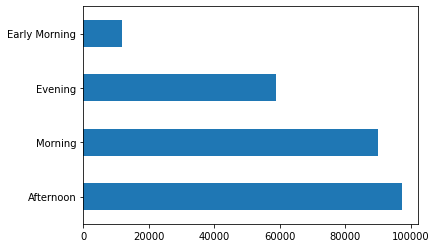

In [ ]:
#count distinct values for month and visualize in a bar graph
merged.Time_of_Day.value_counts().plot(kind = 'barh')

Most accidents happen in the morning (6-13) and afternoon (13-18). Now let's see the distribution by accident severity. 

Accident_Severity  Fatal  Serious  Slight
Time_of_Day                              
Early Morning        373     2110    9319
Morning              891    11055   77928
Afternoon            973    12616   83779
Evening              659     8418   49691


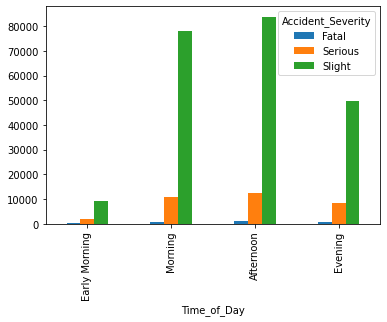

In [ ]:
#plot accident severity against time of day
#cross tabulation between 'Time_of_Day' and 'Accident_Severity'
CrosstabResult=pd.crosstab(index=merged['Time_of_Day'],columns=merged['Accident_Severity'])
print(CrosstabResult)
 
#grouped bar chart between 'Month' and 'Accident_Severity'
CrosstabResult.plot.bar()

The distribution of accident severity is similar to the distribution of accidents overall. Let's move on to the association rules algorithm to see if we find any patterns in conditions that lead to accidents. 

#####*Preparing the data for the association rules algorithm*
It's now time to prepare our data for the association rules algorithm. First, we will drop any columns no longer needed. Then, we *will* make sure all columns are categorical values as that is the data type required for the algorithm to work.  

In [ ]:
#drop 'Date', 'Time', and 'Hour' column since we have columns for month, day of week, and time of day
merged.drop(['Date', 'Time', 'Hour'], axis=1, inplace=True)

#make the accident_index column the index for the dataframe since it will not be an association rules variable
merged.set_index('Accident_Index')

,1st_Road_Class,2nd_Road_Class,Accident_Severity,Carriageway_Hazards,Day_of_Week,Junction_Control,Junction_Detail,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Urban_or_Rural_Area,Weather_Conditions,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,make,Propulsion_Code,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Month,Time_of_Day
Accident_Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
201501BS70001,C,Unclassified,Slight,None,Monday,Give way or uncontrolled,T or staggered junction,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,1,1,0.0,Metropolitan Police,Dry,Single carriageway,30.0,Urban,Fine no high winds,Data missing or out of range,4.0,Data missing or out of range,NaN,2143.0,None,None,Journey as part of work,MERCEDES,Heavy oil,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Van / Goods 3.5 tonnes mgw or under,No,Front,1,Evening
201501BS70002,Unclassified,A,Slight,None,Monday,Give way or uncontrolled,T or staggered junction,Daylight,Kensington and Chelsea,Kensington and Chelsea,1,1,0.0,Metropolitan Police,Dry,Single carriageway,30.0,Urban,Fine no high winds,Data missing or out of range,3.0,Data missing or out of range,NaN,1600.0,None,None,Not known,BMW,Petrol,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Car,No,Front,1,Morning
201501BS70004,B,Unclassified,Slight,None,Monday,Give way or uncontrolled,Mini-roundabout,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,1,1,1.0,Metropolitan Police,Wet or damp,Single carriageway,30.0,Urban,Raining no high winds,26 - 35,10.0,Urban area,NaN,1686.0,None,None,Not known,VAUXHALL,Heavy oil,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Car,No,Front,1,Evening
201501BS70005,B,Unclassified,Slight,None,Tuesday,Give way or uncontrolled,Crossroads,Daylight,Kensington and Chelsea,Kensington and Chelsea,1,1,0.0,Metropolitan Police,Wet or damp,Single carriageway,30.0,Urban,Fine no high winds,Data missing or out of range,NaN,Data missing or out of range,NaN,NaN,None,None,Not known,NaN,NaN,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Car,No,Front,1,Morning
201501BS70008,A,A,Serious,None,Friday,Auto traffic signal,Crossroads,Daylight,Kensington and Chelsea,Kensington and Chelsea,1,2,5.0,Metropolitan Police,Wet or damp,Single carriageway,30.0,Urban,Raining no high winds,46 - 55,NaN,Urban area,NaN,NaN,None,None,Commuting to/from work,NaN,NaN,Male,None,No tow/articulation,Did not leave carriageway,Going ahead other,1,Pedal cycle,No,Did not impact,1,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015984141415,A(M),NaN,Slight,None,Thursday,Data missing or out of range,Not at junction or within 20 metres,Darkness - no lighting,Dumfries and Galloway,Dumfries & Galloway,7,13,0.0,Dumfries and Galloway,Frost or ice,Dual carriageway,70.0,Rural,Snowing no high winds,56 - 65,1.0,Urban area,NaN,1242.0,None,None,Not known,SUZUKI,Petrol,Male,Skidded,No tow/articulation,Did not leave carriageway,Going ahead other,9,Car,No,Front,12,Afternoon
2015984141415,A(M),NaN,Slight,None,Thursday,Data missing or out of range,Not at junction or within 20 metres,Darkness - no lighting,Dumfries and Galloway,Dumfries & Galloway,7,13,0.0,Dumfries and Galloway,Frost or ice,Dual carriageway,70.0,Rural,Snowing no high winds,16 - 20,NaN,Small town,NaN,1422.0,None,None,Not known,SKODA,Heavy oil,Male,Skidded,No tow/articulation,Nearside,Going ahead other,10,

We will need to group/bin some of the variables to make them categorical. Before we bin each, we'll look at the distribution of values to inform the binning. 

In [ ]:
#review distribution of speed limit to inform binning
merged['Speed_limit'].describe()

count    257845.000000
mean         38.702088
std          14.212446
min           0.000000
25%          30.000000
50%          30.000000
75%          50.000000
max          70.000000
Name: Speed_limit, dtype: float64

In [ ]:
merged['Speed_limit'].value_counts()

30.0    161054
60.0     34257
40.0     23113
70.0     20729
50.0     11426
20.0      7261
10.0         3
0.0          2
Name: Speed_limit, dtype: int64

The speed limit is in increments of 10 with only 2 for 0 and 3 for 10. Because of their low counts, let's drop those rows. In doing so, we don't need to bin the remaining 6 speed limits. 

In [ ]:
#drop rows with 0 or 10 speed limit
merged.drop(merged.loc[merged['Speed_limit'] == 0.0].index, inplace=True)
merged.drop(merged.loc[merged['Speed_limit'] == 10.0].index, inplace=True)

#confirm rows dropped
merged['Speed_limit'].value_counts()

30.0    161054
60.0     34257
40.0     23113
70.0     20729
50.0     11426
20.0      7261
Name: Speed_limit, dtype: int64

Let's repeat the steps for age of vehicle

In [ ]:
#review distribution of vehicle age to inform binning
merged['Age_of_Vehicle'].describe()

count    176074.000000
mean          8.011348
std           4.995229
min           1.000000
25%           4.000000
50%           8.000000
75%          11.000000
max         105.000000
Name: Age_of_Vehicle, dtype: float64

In [ ]:
merged['Age_of_Vehicle'].value_counts()

1.0      15360
2.0      12895
8.0      12755
10.0     12097
9.0      12059
         ...  
84.0         1
90.0         1
104.0        1
105.0        1
79.0         1
Name: Age_of_Vehicle, Length: 72, dtype: int64

Basedon the distribution, age of vehicle does need to be binned. But first, let's drop all rows with a vehicle age over 50 as there are so few records. 

In [ ]:
#delete rows with age of vehicle is over 50
merged.drop(merged.loc[merged['Age_of_Vehicle'] > 50.0].index, inplace=True)

#bin age of vehicle
merged['Grouped_Vehicle_Age'] = pd.cut(merged['Age_of_Vehicle'], 
                    bins=[1,10,20,30,40,50], 
                    include_lowest=True, labels=['0-10','10-21','21-30','31-40', '41-50'],
                    precision=0) 

merged.head()

,Accident_Index,1st_Road_Class,2nd_Road_Class,Accident_Severity,Carriageway_Hazards,Day_of_Week,Junction_Control,Junction_Detail,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Urban_or_Rural_Area,Weather_Conditions,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,make,Propulsion_Code,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Month,Time_of_Day,Grouped_Vehicle_Age
0,201501BS70001,C,Unclassified,Slight,None,Monday,Give way or uncontrolled,T or staggered junction,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,1,1,0.0,Metropolitan Police,Dry,Single carriageway,30.0,Urban,Fine no high winds,Data missing or out of range,4.0,Data missing or out of range,NaN,2143.0,None,None,Journey as part of work,MERCEDES,Heavy oil,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Van / Goods 3.5 tonnes mgw or under,No,Front,1,Evening,0-10
1,201501BS70002,Unclassified,A,Slight,None,Monday,Give way or uncontrolled,T or staggered junction,Daylight,Kensington and Chelsea,Kensington and Chelsea,1,1,0.0,Metropolitan Police,Dry,Single carriageway,30.0,Urban,Fine no high winds,Data missing or out of range,3.0,Data missing or out of range,NaN,1600.0,None,None,Not known,BMW,Petrol,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Car,No,Front,1,Morning,0-10
2,201501BS70004,B,Unclassified,Slight,None,Monday,Give way or uncontrolled,Mini-roundabout,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,1,1,1.0,Metropolitan Police,Wet or damp,Single carriageway,30.0,Urban,Raining no high winds,26 - 35,10.0,Urban area,NaN,1686.0,None,None,Not known,VAUXHALL,Heavy oil,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Car,No,Front,1,Evening,0-10
3,201501BS70005,B,Unclassified,Slight,None,Tuesday,Give way or uncontrolled,Crossroads,Daylight,Kensington and Chelsea,Kensington and Chelsea,1,1,0.0,Metropolitan Police,Wet or damp,Single carriageway,30.0,Urban,Fine no high winds,Data missing or out of range,NaN,Data missing or out of range,NaN,NaN,None,None,Not known,NaN,NaN,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Car,No,Front,1,Morning,NaN
4,201501BS70008,A,A,Serious,None,Friday,Auto traffic signal,Crossroads,Daylight,Kensington and Chelsea,Kensington and Chelsea,1,2,5.0,Metropolitan Police,Wet or damp,Single carriageway,30.0,Urban,Raining no high winds,46 - 55,NaN,Urban area,NaN,NaN,None,None,Commuting to/from work,NaN,NaN,Male,None,No tow/articulation,Did not leave carriageway,Going ahead other,1,Pedal cycle,No,Did not impact,1,Morning,NaN


In [ ]:
merged['Grouped_Vehicle_Age'].value_counts()

0-10     120703
10-21     53553
21-30      1504
31-40       196
41-50        68
Name: Grouped_Vehicle_Age, dtype: int64

In [ ]:
#drop column that we converted to bins
merged.drop(['Age_of_Vehicle'], axis=1, inplace=True)
merged.head()

,Accident_Index,1st_Road_Class,2nd_Road_Class,Accident_Severity,Carriageway_Hazards,Day_of_Week,Junction_Control,Junction_Detail,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Urban_or_Rural_Area,Weather_Conditions,Age_Band_of_Driver,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,make,Propulsion_Code,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Month,Time_of_Day,Grouped_Vehicle_Age
0,201501BS70001,C,Unclassified,Slight,None,Monday,Give way or uncontrolled,T or staggered junction,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,1,1,0.0,Metropolitan Police,Dry,Single carriageway,30.0,Urban,Fine no high winds,Data missing or out of range,Data missing or out of range,NaN,2143.0,None,None,Journey as part of work,MERCEDES,Heavy oil,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Van / Goods 3.5 tonnes mgw or under,No,Front,1,Evening,0-10
1,201501BS70002,Unclassified,A,Slight,None,Monday,Give way or uncontrolled,T or staggered junction,Daylight,Kensington and Chelsea,Kensington and Chelsea,1,1,0.0,Metropolitan Police,Dry,Single carriageway,30.0,Urban,Fine no high winds,Data missing or out of range,Data missing or out of range,NaN,1600.0,None,None,Not known,BMW,Petrol,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Car,No,Front,1,Morning,0-10
2,201501BS70004,B,Unclassified,Slight,None,Monday,Give way or uncontrolled,Mini-roundabout,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,1,1,1.0,Metropolitan Police,Wet or damp,Single carriageway,30.0,Urban,Raining no high winds,26 - 35,Urban area,NaN,1686.0,None,None,Not known,VAUXHALL,Heavy oil,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Car,No,Front,1,Evening,0-10
3,201501BS70005,B,Unclassified,Slight,None,Tuesday,Give way or uncontrolled,Crossroads,Daylight,Kensington and Chelsea,Kensington and Chelsea,1,1,0.0,Metropolitan Police,Wet or damp,Single carriageway,30.0,Urban,Fine no high winds,Data missing or out of range,Data missing or out of range,NaN,NaN,None,None,Not known,NaN,NaN,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Car,No,Front,1,Morning,NaN
4,201501BS70008,A,A,Serious,None,Friday,Auto traffic signal,Crossroads,Daylight,Kensington and Chelsea,Kensington and Chelsea,1,2,5.0,Metropolitan Police,Wet or damp,Single carriageway,30.0,Urban,Raining no high winds,46 - 55,Urban area,NaN,NaN,None,None,Commuting to/from work,NaN,NaN,Male,None,No tow/articulation,Did not leave carriageway,Going ahead other,1,Pedal cycle,No,Did not impact,1,Morning,NaN


Month is currently an integer, so we will change it to the month name.

In [ ]:
#convert month integer to month name
import calendar
merged['Month'] = merged['Month'].apply(lambda x: calendar.month_abbr[x])
merged.head()

,Accident_Index,1st_Road_Class,2nd_Road_Class,Accident_Severity,Carriageway_Hazards,Day_of_Week,Junction_Control,Junction_Detail,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Urban_or_Rural_Area,Weather_Conditions,Age_Band_of_Driver,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,make,Propulsion_Code,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Month,Time_of_Day,Grouped_Vehicle_Age
0,201501BS70001,C,Unclassified,Slight,None,Monday,Give way or uncontrolled,T or staggered junction,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,1,1,0.0,Metropolitan Police,Dry,Single carriageway,30.0,Urban,Fine no high winds,Data missing or out of range,Data missing or out of range,NaN,2143.0,None,None,Journey as part of work,MERCEDES,Heavy oil,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Van / Goods 3.5 tonnes mgw or under,No,Front,Jan,Evening,0-10
1,201501BS70002,Unclassified,A,Slight,None,Monday,Give way or uncontrolled,T or staggered junction,Daylight,Kensington and Chelsea,Kensington and Chelsea,1,1,0.0,Metropolitan Police,Dry,Single carriageway,30.0,Urban,Fine no high winds,Data missing or out of range,Data missing or out of range,NaN,1600.0,None,None,Not known,BMW,Petrol,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Car,No,Front,Jan,Morning,0-10
2,201501BS70004,B,Unclassified,Slight,None,Monday,Give way or uncontrolled,Mini-roundabout,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,1,1,1.0,Metropolitan Police,Wet or damp,Single carriageway,30.0,Urban,Raining no high winds,26 - 35,Urban area,NaN,1686.0,None,None,Not known,VAUXHALL,Heavy oil,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Car,No,Front,Jan,Evening,0-10
3,201501BS70005,B,Unclassified,Slight,None,Tuesday,Give way or uncontrolled,Crossroads,Daylight,Kensington and Chelsea,Kensington and Chelsea,1,1,0.0,Metropolitan Police,Wet or damp,Single carriageway,30.0,Urban,Fine no high winds,Data missing or out of range,Data missing or out of range,NaN,NaN,None,None,Not known,NaN,NaN,Male,None,No tow/articulation,Did not leave carriageway,Turning right,1,Car,No,Front,Jan,Morning,NaN
4,201501BS70008,A,A,Serious,None,Friday,Auto traffic signal,Crossroads,Daylight,Kensington and Chelsea,Kensington and Chelsea,1,2,5.0,Metropolitan Police,Wet or damp,Single carriageway,30.0,Urban,Raining no high winds,46 - 55,Urban area,NaN,NaN,None,None,Commuting to/from work,NaN,NaN,Male,None,No tow/articulation,Did not leave carriageway,Going ahead other,1,Pedal cycle,No,Did not impact,Jan,Morning,NaN


Last, we need to convert columns we plan to include to boolean by using get_dummies, allowing the algorithm to work. 

In [ ]:
#create a dataframe with only variables we want to use
accidents = merged[['Accident_Severity', 'Carriageway_Hazards', 'Day_of_Week', \
                   'Junction_Control', 'Junction_Detail','Light_Conditions', 'Road_Surface_Conditions',\
                   'Road_Type', 'Speed_limit', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Age_Band_of_Driver',\
                   'Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Vehicle_Manoeuvre', 'Month',\
                   'Time_of_Day', 'Grouped_Vehicle_Age']].copy()
accidents.head()

,Accident_Severity,Carriageway_Hazards,Day_of_Week,Junction_Control,Junction_Detail,Light_Conditions,Road_Surface_Conditions,Road_Type,Speed_limit,Urban_or_Rural_Area,Weather_Conditions,Age_Band_of_Driver,Journey_Purpose_of_Driver,Sex_of_Driver,Vehicle_Manoeuvre,Month,Time_of_Day,Grouped_Vehicle_Age
0,Slight,None,Monday,Give way or uncontrolled,T or staggered junction,Darkness - lights lit,Dry,Single carriageway,30.0,Urban,Fine no high winds,Data missing or out of range,Journey as part of work,Male,Turning right,Jan,Evening,0-10
1,Slight,None,Monday,Give way or uncontrolled,T or staggered junction,Daylight,Dry,Single carriageway,30.0,Urban,Fine no high winds,Data missing or out of range,Not known,Male,Turning right,Jan,Morning,0-10
2,Slight,None,Monday,Give way or uncontrolled,Mini-roundabout,Darkness - lights lit,Wet or damp,Single carriageway,30.0,Urban,Raining no high winds,26 - 35,Not known,Male,Turning right,Jan,Evening,0-10
3,Slight,None,Tuesday,Give way or uncontrolled,Crossroads,Daylight,Wet or damp,Single carriageway,30.0,Urban,Fine no high winds,Data missing or out of range,Not known,Male,Turning right,Jan,Morning,NaN
4,Serious,None,Friday,Auto traffic signal,Crossroads,Daylight,Wet or damp,Single carriageway,30.0,Urban,Raining no high winds,46 - 55,Commuting to/from work,Male,Going ahead other,Jan,Morning,NaN


In [ ]:
#convert speed limit to string so we can one hot encode
accidents['Speed_limit'] = accidents['Speed_limit'].astype(str)

In [ ]:
#save accidents to google drive
accidents.to_csv('/content/drive/MyDrive/Data Science/Collaboration with Adam M/Association project/accidents_cleaned.csv', index=True)

In [ ]:
#get dummies for all columns
accidents = pd.get_dummies(accidents)
accidents.head()

,Accident_Severity_Fatal,Accident_Severity_Serious,Accident_Severity_Slight,Carriageway_Hazards_Any animal in carriageway (except ridden horse),Carriageway_Hazards_Data missing or out of range,Carriageway_Hazards_None,Carriageway_Hazards_Other object on road,Carriageway_Hazards_Pedestrian in carriageway - not injured,Carriageway_Hazards_Previous accident,Carriageway_Hazards_Vehicle load on road,Day_of_Week_Friday,Day_of_Week_Monday,Day_of_Week_Saturday,Day_of_Week_Sunday,Day_of_Week_Thursday,Day_of_Week_Tuesday,Day_of_Week_Wednesday,Junction_Control_Authorised person,Junction_Control_Auto traffic signal,Junction_Control_Data missing or out of range,Junction_Control_Give way or uncontrolled,Junction_Control_Stop sign,Junction_Detail_Crossroads,Junction_Detail_Data missing or out of range,Junction_Detail_Mini-roundabout,Junction_Detail_More than 4 arms (not roundabout),Junction_Detail_Not at junction or within 20 metres,Junction_Detail_Other junction,Junction_Detail_Private drive or entrance,Junction_Detail_Roundabout,Junction_Detail_Slip road,Junction_Detail_T or staggered junction,Light_Conditions_Darkness - lighting unknown,Light_Conditions_Darkness - lights lit,Light_Conditions_Darkness - lights unlit,Light_Conditions_Darkness - no lighting,Light_Conditions_Daylight,Road_Surface_Conditions_Data missing or out of range,Road_Surface_Conditions_Dry,Road_Surface_Conditions_Flood over 3cm. deep,...,Vehicle_Manoeuvre_Changing lane to left,Vehicle_Manoeuvre_Changing lane to right,Vehicle_Manoeuvre_Data missing or out of range,Vehicle_Manoeuvre_Going ahead left-hand bend,Vehicle_Manoeuvre_Going ahead other,Vehicle_Manoeuvre_Going ahead right-hand bend,Vehicle_Manoeuvre_Moving off,Vehicle_Manoeuvre_Overtaking - nearside,Vehicle_Manoeuvre_Overtaking moving vehicle - offside,Vehicle_Manoeuvre_Overtaking static vehicle - offside,Vehicle_Manoeuvre_Parked,Vehicle_Manoeuvre_Reversing,Vehicle_Manoeuvre_Slowing or stopping,Vehicle_Manoeuvre_Turning left,Vehicle_Manoeuvre_Turning right,Vehicle_Manoeuvre_U-turn,Vehicle_Manoeuvre_Waiting to go - held up,Vehicle_Manoeuvre_Waiting to turn left,Vehicle_Manoeuvre_Waiting to turn right,Month_Apr,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Time_of_Day_Early Morning,Time_of_Day_Morning,Time_of_Day_Afternoon,Time_of_Day_Evening,Grouped_Vehicle_Age_0-10,Grouped_Vehicle_Age_10-21,Grouped_Vehicle_Age_21-30,Grouped_Vehicle_Age_31-40,Grouped_Vehicle_Age_41-50
0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
2,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
3,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


Let's look at the column names to identify columns to drop based on previously missing data or similar. 

In [ ]:
accidents.columns.values.tolist()

['Accident_Severity_Fatal',
 'Accident_Severity_Serious',
 'Accident_Severity_Slight',
 'Carriageway_Hazards_Any animal in carriageway (except ridden horse)',
 'Carriageway_Hazards_Data missing or out of range',
 'Carriageway_Hazards_None',
 'Carriageway_Hazards_Other object on road',
 'Carriageway_Hazards_Pedestrian in carriageway - not injured',
 'Carriageway_Hazards_Previous accident',
 'Carriageway_Hazards_Vehicle load on road',
 'Day_of_Week_Friday',
 'Day_of_Week_Monday',
 'Day_of_Week_Saturday',
 'Day_of_Week_Sunday',
 'Day_of_Week_Thursday',
 'Day_of_Week_Tuesday',
 'Day_of_Week_Wednesday',
 'Junction_Control_Authorised person',
 'Junction_Control_Auto traffic signal',
 'Junction_Control_Data missing or out of range',
 'Junction_Control_Give way or uncontrolled',
 'Junction_Control_Stop sign',
 'Junction_Detail_Crossroads',
 'Junction_Detail_Data missing or out of range',
 'Junction_Detail_Mini-roundabout',
 'Junction_Detail_More than 4 arms (not roundabout)',
 'Junction_Detail

In [ ]:
#drop identified columns with missing values
accidents.drop(['Carriageway_Hazards_Data missing or out of range', 'Junction_Control_Data missing or out of range',\
                'Light_Conditions_Darkness - lighting unknown', 'Road_Surface_Conditions_Data missing or out of range',\
                'Road_Type_Unknown', 'Weather_Conditions_Unknown', 'Age_Band_of_Driver_Data missing or out of range',\
                'Journey_Purpose_of_Driver_Data missing or out of range', 'Journey_Purpose_of_Driver_Not known', 'Sex_of_Driver_Not known',\
                'Sex_of_Driver_Data missing or out of range', 'Vehicle_Manoeuvre_Data missing or out of range'], axis=1, inplace=True)
accidents.head()

,Accident_Severity_Fatal,Accident_Severity_Serious,Accident_Severity_Slight,Carriageway_Hazards_Any animal in carriageway (except ridden horse),Carriageway_Hazards_None,Carriageway_Hazards_Other object on road,Carriageway_Hazards_Pedestrian in carriageway - not injured,Carriageway_Hazards_Previous accident,Carriageway_Hazards_Vehicle load on road,Day_of_Week_Friday,Day_of_Week_Monday,Day_of_Week_Saturday,Day_of_Week_Sunday,Day_of_Week_Thursday,Day_of_Week_Tuesday,Day_of_Week_Wednesday,Junction_Control_Authorised person,Junction_Control_Auto traffic signal,Junction_Control_Give way or uncontrolled,Junction_Control_Stop sign,Junction_Detail_Crossroads,Junction_Detail_Data missing or out of range,Junction_Detail_Mini-roundabout,Junction_Detail_More than 4 arms (not roundabout),Junction_Detail_Not at junction or within 20 metres,Junction_Detail_Other junction,Junction_Detail_Private drive or entrance,Junction_Detail_Roundabout,Junction_Detail_Slip road,Junction_Detail_T or staggered junction,Light_Conditions_Darkness - lights lit,Light_Conditions_Darkness - lights unlit,Light_Conditions_Darkness - no lighting,Light_Conditions_Daylight,Road_Surface_Conditions_Dry,Road_Surface_Conditions_Flood over 3cm. deep,Road_Surface_Conditions_Frost or ice,Road_Surface_Conditions_Snow,Road_Surface_Conditions_Wet or damp,Road_Type_Dual carriageway,...,Sex_of_Driver_Male,Vehicle_Manoeuvre_Changing lane to left,Vehicle_Manoeuvre_Changing lane to right,Vehicle_Manoeuvre_Going ahead left-hand bend,Vehicle_Manoeuvre_Going ahead other,Vehicle_Manoeuvre_Going ahead right-hand bend,Vehicle_Manoeuvre_Moving off,Vehicle_Manoeuvre_Overtaking - nearside,Vehicle_Manoeuvre_Overtaking moving vehicle - offside,Vehicle_Manoeuvre_Overtaking static vehicle - offside,Vehicle_Manoeuvre_Parked,Vehicle_Manoeuvre_Reversing,Vehicle_Manoeuvre_Slowing or stopping,Vehicle_Manoeuvre_Turning left,Vehicle_Manoeuvre_Turning right,Vehicle_Manoeuvre_U-turn,Vehicle_Manoeuvre_Waiting to go - held up,Vehicle_Manoeuvre_Waiting to turn left,Vehicle_Manoeuvre_Waiting to turn right,Month_Apr,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Time_of_Day_Early Morning,Time_of_Day_Morning,Time_of_Day_Afternoon,Time_of_Day_Evening,Grouped_Vehicle_Age_0-10,Grouped_Vehicle_Age_10-21,Grouped_Vehicle_Age_21-30,Grouped_Vehicle_Age_31-40,Grouped_Vehicle_Age_41-50
0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
2,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
3,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
#save to g drive
accidents.to_csv('/content/drive/MyDrive/Kaggle/accidents_cleaned.csv', index=True)

#####*Running the association rules algorithm*

Descriptive analyses revealed the majority of incidents to be ‘slight’. Therefore, we decided upon a higher Support parameter of 0.1, meaning that the combination of conditions occur at least 10 times in 100 incidents. We chose combinations of only 2 antecedents due to the visualisation methods we elected to use, and held the Lift parameter at 1 to identify stronger associations.

There were fewer serious accidents than slight. Therefore, we decided to set the Support parameter at 0.05, meaning the combination of conditions identified had to occur at least 5 out of 100 times across the data set. The remaining parameters were held constant (i.e., antecedent combinations was 2, and Lift was 1).

Descriptive analyses revealed far fewer fatal incidents compared to serious and slight, thus we decided to set the Support paramater at 0.01, meaning the combination of conditions identified had to occur at least 1 time out of 100 times across the data set. Again, the remaining parameters were held constant. 

Now, let's run the association rules algorithm for each accident type, adjusting the support to reflect the proportion of the data with that level of severity.

In [ ]:
#Apriori min support for serious accidents - medium support
min_support = 0.05

#Max lenght of apriori n-grams
max_len = 2

frequent_items = apriori(accidents, use_colnames=True, min_support=min_support, max_len=max_len + 1)
rules = association_rules(frequent_items, metric='lift', min_threshold=1)

target = '{\'Accident_Severity_Serious\'}'

results_attrition_serious = rules[rules['consequents'].astype(str).str.contains(target)].sort_values(by='confidence', ascending=False)

#add a 'length' column to capture the length of antecedents for futher filtering later
results_attrition_serious['length'] = results_attrition_serious['antecedents'].apply(lambda x: len(x))

print(results_attrition_serious.shape)
results_attrition_serious

(40, 10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length
4,(Urban_or_Rural_Area_Rural),(Accident_Severity_Serious),0.351329,0.13262,0.058683,0.167033,1.259489,0.012090,1.041314,1
736,"(Urban_or_Rural_Area_Rural, Carriageway_Hazard...",(Accident_Severity_Serious),0.342484,0.13262,0.056961,0.166317,1.254094,0.011541,1.040420,2
836,"(Sex_of_Driver_Male, Vehicle_Manoeuvre_Going a...",(Accident_Severity_Serious),0.321871,0.13262,0.050665,0.157409,1.186920,0.007979,1.029420,2
9828,"(Road_Type_Single carriageway, Sex_of_Driver_M...",(Accident_Severity_Serious),0.394430,0.13262,0.061088,0.154878,1.167837,0.008779,1.026338,3
0,(Junction_Detail_Not at junction or within 20 ...,(Accident_Severity_Serious),0.388184,0.13262,0.059723,0.153852,1.160103,0.008242,1.025093,1
726,(Junction_Detail_Not at junction or within 20 ...,(Accident_Severity_Serious),0.378195,0.13262,0.058059,0.153516,1.157563,0.007903,1.024686,2
800,"(Road_Type_Single carriageway, Sex_of_Driver_M...",(Accident_Severity_Serious),0.477544,0.13262,0.073222,0.153331,1.156174,0.009891,1.024463,2
9608,"(Road_Type_Single carriageway, Sex_of_Driver_M...",(Accident_Severity_Serious),0.470759,0.13262,0.072028,0.153003,1.153699,0.009596,1.024066,3
806,"(Road_Type_Single carriageway, Vehicle_Manoeuv...",(Accident_Severity_Serious),0.337690,0.13262,0.051181,0.151563,1.142839,0.006397,1.022327,2
9770,"(Road_Type_Single carriageway, Road_Surface_Co...",(Accident_Severity_Serious),0.350968,0.13262,0.053117,0.151344,1.141189,0.006572,1.022064,3


There are 40 association rules when accident severity is serious. 

In [ ]:
#Apriori min support for fatal accidents - lowest support
min_support = 0.01

#Max lenght of apriori n-grams
max_len = 2

frequent_items = apriori(accidents, use_colnames=True, min_support=min_support, max_len=max_len + 1)
rules = association_rules(frequent_items, metric='lift', min_threshold=1)

target = '{\'Accident_Severity_Fatal\'}'

results_attrition_fatal = rules[rules['consequents'].astype(str).str.contains(target)].sort_values(by='confidence', ascending=False)

#add a 'length' column to capture the length of antecedents for futher filtering later
results_attrition_fatal['length'] = results_attrition_fatal['antecedents'].apply(lambda x: len(x))

results_attrition_fatal

There are no association rules when accident severity is fatal.

In [ ]:
#Apriori min support for slight - highest support
min_support = 0.1

#Max lenght of apriori n-grams
max_len = 2

frequent_items = apriori(accidents, use_colnames=True, min_support=min_support, max_len=max_len + 1)
rules = association_rules(frequent_items, metric='lift', min_threshold=1)

target = '{\'Accident_Severity_Slight\'}'

results_attrition_slight = rules[rules['consequents'].astype(str).str.contains(target)].sort_values(by='confidence', ascending=False)

#add a 'length' column to capture the length of antecedents for futher filtering later
results_attrition_slight['length'] = results_attrition_slight['antecedents'].apply(lambda x: len(x))

print(results_attrition_slight.shape)
results_attrition_slight

(144, 10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length
908,"(Sex_of_Driver_Female, Urban_or_Rural_Area_Urban)",(Accident_Severity_Slight),0.176877,0.856135,0.159933,0.904204,1.056147,0.008502,1.501790,2
851,"(Sex_of_Driver_Female, Speed_limit_30.0)",(Accident_Severity_Slight),0.172028,0.856135,0.155425,0.903488,1.055311,0.008146,1.490651,2
550,"(Sex_of_Driver_Female, Junction_Control_Give w...",(Accident_Severity_Slight),0.145231,0.856135,0.129877,0.894281,1.044557,0.005540,1.360831,2
706,"(Sex_of_Driver_Female, Light_Conditions_Daylight)",(Accident_Severity_Slight),0.221362,0.856135,0.196881,0.889407,1.038863,0.007365,1.300850,2
920,"(Time_of_Day_Morning, Urban_or_Rural_Area_Urban)",(Accident_Severity_Slight),0.216056,0.856135,0.192160,0.889402,1.038857,0.007187,1.300789,2
...,...,...,...,...,...,...,...,...,...,...
814,"(Road_Type_Single carriageway, Age_Band_of_Dri...",(Accident_Severity_Slight),0.123554,0.856135,0.105908,0.857179,1.001219,0.000129,1.007309,2
652,"(Weather_Conditions_Fine no high winds, Light_...",(Accident_Severity_Slight),0.140382,0.856135,0.120307,0.857001,1.001011,0.000122,1.006055,2
5,(Carriageway_Hazards_None),(Accident_Severity_Slight),0.984736,0.856135,0.843640,0.856717,1.000680,0.000574,1.004066,1
1010,"(Time_of_Day_Morning, Vehicle_Manoeuvre_Going ...",(Accident_Severity_Slight),0.159898,0.856135,0.136937,0.856405,1.000315,0.000043,1.001879,2


There are 144 association rules when accident severity is slight.

In [ ]:
#the apriori algorithm is computationally heavy - save results to G Drive for future access
results_attrition_slight.to_csv('/content/drive/MyDrive/Data Science/Association project/assoc_accidents_slight_updated.csv', index=True)
results_attrition_serious.to_csv('/content/drive/MyDrive/Data Science/Association project/assoc_accidents_severe_updated.csv', index=True)

#####*Preparing the severe accident data to visualize the output*

In [ ]:
#Create dataframe using csv file previously shared in my G Drive
results_attrition_serious=pd.read_csv('/content/drive/MyDrive/Data Science/Association project/assoc_accidents_severe_updated.csv')
#drop old index
results_attrition_serious.drop(['Unnamed: 0'], axis=1, inplace=True)
results_attrition_serious.shape #check the shape of the dataframe

(22, 10)

In [ ]:
results_attrition_serious.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length
0,frozenset({'Urban_or_Rural_Area_Rural'}),frozenset({'Accident_Severity_Serious'}),0.351329,0.13262,0.058683,0.167033,1.259489,0.012090,1.041314,1
1,"frozenset({'Urban_or_Rural_Area_Rural', 'Carri...",frozenset({'Accident_Severity_Serious'}),0.342484,0.13262,0.056961,0.166317,1.254094,0.011541,1.040420,2
2,"frozenset({'Sex_of_Driver_Male', 'Vehicle_Mano...",frozenset({'Accident_Severity_Serious'}),0.321871,0.13262,0.050665,0.157409,1.186920,0.007979,1.029420,2
3,frozenset({'Junction_Detail_Not at junction or...,frozenset({'Accident_Severity_Serious'}),0.388184,0.13262,0.059723,0.153852,1.160103,0.008242,1.025093,1
4,frozenset({'Junction_Detail_Not at junction or...,frozenset({'Accident_Severity_Serious'}),0.378195,0.13262,0.058059,0.153516,1.157563,0.007903,1.024686,2


In [ ]:
results_attrition_serious.dtypes

antecedents            object
consequents            object
antecedent support    float64
consequent support    float64
support               float64
confidence            float64
lift                  float64
leverage              float64
conviction            float64
length                  int64
dtype: object

In [ ]:
#convert antecedents column to string
results_attrition_serious['antecedents']= results_attrition_serious['antecedents'].astype(str)

In [ ]:
#split the antecedents into two columns
# new data frame with split value columns
split = results_attrition_serious["antecedents"].str.split(", ", n = 1, expand = True)
split.head()

,0,1
0,frozenset({'Urban_or_Rural_Area_Rural'}),None
1,frozenset({'Urban_or_Rural_Area_Rural','Carriageway_Hazards_None'})
2,frozenset({'Sex_of_Driver_Male','Vehicle_Manoeuvre_Going ahead other'})
3,frozenset({'Junction_Detail_Not at junction or...,None
4,frozenset({'Junction_Detail_Not at junction or...,'Carriageway_Hazards_None'})


In [ ]:
# make separate antecedent columns from new data frame
results_attrition_serious["antecedent_1"]= split[0]
results_attrition_serious["antecedent_2"]= split[1]
 
# Drop old antecedent column
results_attrition_serious.drop(columns =["antecedents"], inplace = True)

results_attrition_serious.head()

,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length,antecedent_1,antecedent_2
0,frozenset({'Accident_Severity_Serious'}),0.351329,0.13262,0.058683,0.167033,1.259489,0.012090,1.041314,1,frozenset({'Urban_or_Rural_Area_Rural'}),None
1,frozenset({'Accident_Severity_Serious'}),0.342484,0.13262,0.056961,0.166317,1.254094,0.011541,1.040420,2,frozenset({'Urban_or_Rural_Area_Rural','Carriageway_Hazards_None'})
2,frozenset({'Accident_Severity_Serious'}),0.321871,0.13262,0.050665,0.157409,1.186920,0.007979,1.029420,2,frozenset({'Sex_of_Driver_Male','Vehicle_Manoeuvre_Going ahead other'})
3,frozenset({'Accident_Severity_Serious'}),0.388184,0.13262,0.059723,0.153852,1.160103,0.008242,1.025093,1,frozenset({'Junction_Detail_Not at junction or...,None
4,frozenset({'Accident_Severity_Serious'}),0.378195,0.13262,0.058059,0.153516,1.157563,0.007903,1.024686,2,frozenset({'Junction_Detail_Not at junction or...,'Carriageway_Hazards_None'})


In [ ]:
#trim antecedent columns down to just the variable
results_attrition_serious['antecedent_1'] = results_attrition_serious['antecedent_1'].map(lambda x: x.lstrip('frozenset({').rstrip('})'))
results_attrition_serious['antecedent_2'] = results_attrition_serious['antecedent_2'].str.rstrip('})')

#trim antecedent columns down to just the variable when working from saved csv version
results_attrition_serious['consequents'] = results_attrition_serious['consequents'].map(lambda x: x.lstrip('frozenset({').rstrip('})'))

results_attrition_serious.head()

,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length,antecedent_1,antecedent_2
0,'Accident_Severity_Serious',0.351329,0.13262,0.058683,0.167033,1.259489,0.012090,1.041314,1,'Urban_or_Rural_Area_Rural',None
1,'Accident_Severity_Serious',0.342484,0.13262,0.056961,0.166317,1.254094,0.011541,1.040420,2,'Urban_or_Rural_Area_Rural','Carriageway_Hazards_None'
2,'Accident_Severity_Serious',0.321871,0.13262,0.050665,0.157409,1.186920,0.007979,1.029420,2,'Sex_of_Driver_Male','Vehicle_Manoeuvre_Going ahead other'
3,'Accident_Severity_Serious',0.388184,0.13262,0.059723,0.153852,1.160103,0.008242,1.025093,1,'Junction_Detail_Not at junction or within 20 ...,None
4,'Accident_Severity_Serious',0.378195,0.13262,0.058059,0.153516,1.157563,0.007903,1.024686,2,'Junction_Detail_Not at junction or within 20 ...,'Carriageway_Hazards_None'


In [ ]:
#create a dataframe of the unique values for antecedent 1
value_counts_1 = results_attrition_serious['antecedent_1'].value_counts(dropna=True, sort=True)
df_val_counts_1 = pd.DataFrame(value_counts_1)
df_value_counts_reset_1 = df_val_counts_1.reset_index()
df_value_counts_reset_1.columns = ['source', 'value'] # change column names
df_value_counts_reset_1

,source,value
0,'Road_Type_Single carriageway',7
1,'Sex_of_Driver_Male',5
2,'Weather_Conditions_Fine no high winds',3
3,'Urban_or_Rural_Area_Rural',2
4,'Junction_Detail_Not at junction or within 20 ...,2
5,'Vehicle_Manoeuvre_Going ahead other',2
6,'Road_Surface_Conditions_Dry',1


In [ ]:
#create a dataframe of the unique values for antecedent 2
value_counts_2 = results_attrition_serious['antecedent_2'].value_counts(dropna=True, sort=True)
df_val_counts_2 = pd.DataFrame(value_counts_2)
df_value_counts_reset_2 = df_val_counts_2.reset_index()
df_value_counts_reset_2.columns = ['source', 'value'] # change column names
df_value_counts_reset_2

,source,value
0,'Carriageway_Hazards_None',6
1,'Vehicle_Manoeuvre_Going ahead other',3
2,'Light_Conditions_Daylight',2
3,'Weather_Conditions_Fine no high winds',2
4,'Sex_of_Driver_Male',2
5,'Road_Surface_Conditions_Dry',1


In [ ]:
#concat dataframes into 1
all_values_serious = pd.concat([df_value_counts_reset_1, df_value_counts_reset_2], ignore_index=True)
all_values_serious

,source,value
0,'Road_Type_Single carriageway',7
1,'Sex_of_Driver_Male',5
2,'Weather_Conditions_Fine no high winds',3
3,'Urban_or_Rural_Area_Rural',2
4,'Junction_Detail_Not at junction or within 20 ...,2
5,'Vehicle_Manoeuvre_Going ahead other',2
6,'Road_Surface_Conditions_Dry',1
7,'Carriageway_Hazards_None',6
8,'Vehicle_Manoeuvre_Going ahead other',3
9,'Light_Conditions_Daylight',2


In [ ]:
#combine same values and sum counts
all_values_serious = all_values_serious.groupby('source').sum('value')
all_values_serious = all_values_serious.sort_values(by = ['value'], ascending=[False])
all_values_serious

,value
source,
'Road_Type_Single carriageway',7
'Sex_of_Driver_Male',7
'Carriageway_Hazards_None',6
'Vehicle_Manoeuvre_Going ahead other',5
'Weather_Conditions_Fine no high winds',5
'Junction_Detail_Not at junction or within 20 metres',2
'Light_Conditions_Daylight',2
'Road_Surface_Conditions_Dry',2
'Urban_or_Rural_Area_Rural',2


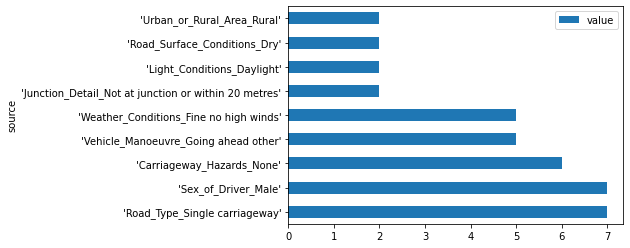

In [ ]:
#plot frequency of variables for severe accidents
all_values_serious.plot(kind = 'barh')

#####*Preparing the slight accident data to visualize the output*


In [ ]:
#Create dataframe using csv file shared in my G Drive
results_attrition_slight=pd.read_csv('/content/drive/MyDrive/Data Science/Association project/assoc_accidents_slight_updated.csv')
#drop old index
results_attrition_slight.drop(['Unnamed: 0'], axis=1, inplace=True)
results_attrition_slight.shape #check the shape of the dataframe

(144, 10)

In [ ]:
results_attrition_slight.dtypes

antecedents            object
consequents            object
antecedent support    float64
consequent support    float64
support               float64
confidence            float64
lift                  float64
leverage              float64
conviction            float64
length                  int64
dtype: object

In [ ]:
#convert antecedents column to string
results_attrition_slight['antecedents']= results_attrition_slight['antecedents'].astype(str)

In [ ]:
#split the antecedents into two columns
# new data frame with split value columns
split = results_attrition_slight["antecedents"].str.split(", ", n = 1, expand = True)

# make separate antecedent columns from new data frame
results_attrition_slight["antecedent_1"]= split[0]
results_attrition_slight["antecedent_2"]= split[1]
 
# Drop old antecedent column
results_attrition_slight.drop(columns =["antecedents"], inplace = True)

results_attrition_slight.head()

,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length,antecedent_1,antecedent_2
0,frozenset({'Accident_Severity_Slight'}),0.176877,0.856135,0.159933,0.904204,1.056147,0.008502,1.501790,2,frozenset({'Sex_of_Driver_Female','Urban_or_Rural_Area_Urban'})
1,frozenset({'Accident_Severity_Slight'}),0.172028,0.856135,0.155425,0.903488,1.055311,0.008146,1.490651,2,frozenset({'Sex_of_Driver_Female','Speed_limit_30.0'})
2,frozenset({'Accident_Severity_Slight'}),0.145231,0.856135,0.129877,0.894281,1.044557,0.005540,1.360831,2,frozenset({'Sex_of_Driver_Female','Junction_Control_Give way or uncontrolled'})
3,frozenset({'Accident_Severity_Slight'}),0.221362,0.856135,0.196881,0.889407,1.038863,0.007365,1.300850,2,frozenset({'Sex_of_Driver_Female','Light_Conditions_Daylight'})
4,frozenset({'Accident_Severity_Slight'}),0.216056,0.856135,0.192160,0.889402,1.038857,0.007187,1.300789,2,frozenset({'Time_of_Day_Morning','Urban_or_Rural_Area_Urban'})


In [ ]:
#trim antecedent columns down to just the variable
results_attrition_slight['antecedent_1'] = results_attrition_slight['antecedent_1'].map(lambda x: x.lstrip('frozenset({').rstrip('})'))
results_attrition_slight['antecedent_2'] = results_attrition_slight['antecedent_2'].str.rstrip('})')

#trim antecedent columns down to just the variable when working from saved csv version
results_attrition_slight['consequents'] = results_attrition_slight['consequents'].map(lambda x: x.lstrip('frozenset({').rstrip('})'))

results_attrition_slight.head()

,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length,antecedent_1,antecedent_2
0,'Accident_Severity_Slight',0.176877,0.856135,0.159933,0.904204,1.056147,0.008502,1.501790,2,'Sex_of_Driver_Female','Urban_or_Rural_Area_Urban'
1,'Accident_Severity_Slight',0.172028,0.856135,0.155425,0.903488,1.055311,0.008146,1.490651,2,'Sex_of_Driver_Female','Speed_limit_30.0'
2,'Accident_Severity_Slight',0.145231,0.856135,0.129877,0.894281,1.044557,0.005540,1.360831,2,'Sex_of_Driver_Female','Junction_Control_Give way or uncontrolled'
3,'Accident_Severity_Slight',0.221362,0.856135,0.196881,0.889407,1.038863,0.007365,1.300850,2,'Sex_of_Driver_Female','Light_Conditions_Daylight'
4,'Accident_Severity_Slight',0.216056,0.856135,0.192160,0.889402,1.038857,0.007187,1.300789,2,'Time_of_Day_Morning','Urban_or_Rural_Area_Urban'


In [ ]:
#create a dataframe of the unique values for antecedent 1
value_counts_1 = results_attrition_slight['antecedent_1'].value_counts(dropna=True, sort=True)
df_val_counts_1 = pd.DataFrame(value_counts_1)
df_value_counts_reset_1 = df_val_counts_1.reset_index()
df_value_counts_reset_1.columns = ['source', 'value'] # change column names
df_value_counts_reset_1

,source,value
0,'Road_Surface_Conditions_Dry',15
1,'Weather_Conditions_Fine no high winds',12
2,'Light_Conditions_Daylight',11
3,'Sex_of_Driver_Female',10
4,'Junction_Detail_T or staggered junction',9
5,'Road_Type_Single carriageway',8
6,'Grouped_Vehicle_Age_0-10',7
7,'Time_of_Day_Afternoon',7
8,'Time_of_Day_Morning',6
9,'Age_Band_of_Driver_26 - 35',5


In [ ]:
#create a dataframe of the unique values for antecedent 2
value_counts_2 = results_attrition_slight['antecedent_2'].value_counts(dropna=True, sort=True)
df_val_counts_2 = pd.DataFrame(value_counts_2)
df_value_counts_reset_2 = df_val_counts_2.reset_index()
df_value_counts_reset_2.columns = ['source', 'value'] # change column names
df_value_counts_reset_2

,source,value
0,'Carriageway_Hazards_None',20
1,'Speed_limit_30.0',18
2,'Urban_or_Rural_Area_Urban',17
3,'Light_Conditions_Daylight',11
4,'Junction_Control_Give way or uncontrolled',10
5,'Weather_Conditions_Fine no high winds',6
6,'Grouped_Vehicle_Age_0-10',6
7,'Vehicle_Manoeuvre_Going ahead other',5
8,'Time_of_Day_Morning',5
9,'Time_of_Day_Afternoon',3


In [ ]:
#concat dataframes into 1
all_values_slight = pd.concat([df_value_counts_reset_1, df_value_counts_reset_2], ignore_index=True)
#combine same values and sum counts
all_values_slight = all_values_slight.groupby('source').sum('value')
all_values_slight = all_values_slight.sort_values(by = ['value'], ascending=[False])
print(all_values_slight.shape)
all_values_slight

(29, 1)


,value
source,
'Carriageway_Hazards_None',22
'Light_Conditions_Daylight',22
'Urban_or_Rural_Area_Urban',21
'Speed_limit_30.0',21
'Weather_Conditions_Fine no high winds',18
'Road_Surface_Conditions_Dry',17
'Junction_Control_Give way or uncontrolled',15
'Grouped_Vehicle_Age_0-10',13
'Junction_Detail_T or staggered junction',11


In [ ]:
#create a new dataframe and drop last 19 rows to keep only the top 10 
top_10_slight = all_values_slight.copy()
top_10_slight.drop(top_10_slight.tail(19).index, inplace = True)
print(top_10_slight.shape)
top_10_slight

(10, 1)


,value
source,
'Carriageway_Hazards_None',22
'Light_Conditions_Daylight',22
'Urban_or_Rural_Area_Urban',21
'Speed_limit_30.0',21
'Weather_Conditions_Fine no high winds',18
'Road_Surface_Conditions_Dry',17
'Junction_Control_Give way or uncontrolled',15
'Grouped_Vehicle_Age_0-10',13
'Junction_Detail_T or staggered junction',11


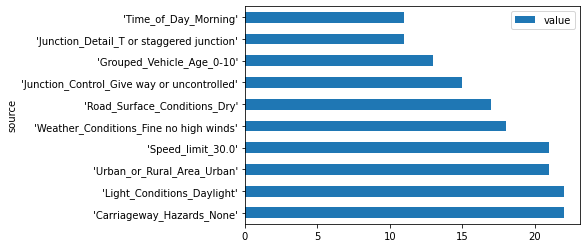

In [ ]:
#plot frequency of variables for slight accidents
top_10_slight.plot(kind = 'barh')

In [ ]:
all_values_severe['target'] = 'Accident_Severity_Severe'
all_values_severe.reset_index(inplace=True)
all_values_severe

,source,value,target
0,'Road_Type_Single carriageway',7,Accident_Severity_Severe
1,'Sex_of_Driver_Male',7,Accident_Severity_Severe
2,'Carriageway_Hazards_None',6,Accident_Severity_Severe
3,'Vehicle_Manoeuvre_Going ahead other',5,Accident_Severity_Severe
4,'Weather_Conditions_Fine no high winds',5,Accident_Severity_Severe
5,'Junction_Detail_Not at junction or within 20 ...,2,Accident_Severity_Severe
6,'Light_Conditions_Daylight',2,Accident_Severity_Severe
7,'Road_Surface_Conditions_Dry',2,Accident_Severity_Severe
8,'Urban_or_Rural_Area_Rural',2,Accident_Severity_Severe


In [ ]:
all_values_slight['target'] = 'Accident_Severity_Slight'
all_values_slight.reset_index(inplace=True)
all_values_slight

,source,value,target
0,'Carriageway_Hazards_None',22,Accident_Severity_Slight
1,'Light_Conditions_Daylight',22,Accident_Severity_Slight
2,'Urban_or_Rural_Area_Urban',21,Accident_Severity_Slight
3,'Speed_limit_30.0',21,Accident_Severity_Slight
4,'Weather_Conditions_Fine no high winds',18,Accident_Severity_Slight
5,'Road_Surface_Conditions_Dry',17,Accident_Severity_Slight
6,'Junction_Control_Give way or uncontrolled',15,Accident_Severity_Slight
7,'Grouped_Vehicle_Age_0-10',13,Accident_Severity_Slight
8,'Junction_Detail_T or staggered junction',11,Accident_Severity_Slight
9,'Time_of_Day_Morning',11,Accident_Severity_Slight


#####*Combine the slight and serious accident data into one dataframe and save to share with Adam*


In [ ]:
#concat both severe and slight dataframes into one
all_assoc = pd.concat([all_values_severe, all_values_slight], ignore_index=True)
all_assoc.shape

(38, 3)

In [ ]:
#save to g drive
all_assoc.to_csv('/content/drive/MyDrive/Data Science/Association project/all_assoc.csv', index=True)

### **Results** <a name="results"></a>



*Associations Rules for Slight Incidents*

The analysis identified 144 association rules, or 144 combinations of two conditions that are associated with a slight incident, at least 10 times out of 100 incidents. These associations were visualised separately, though some basic visualisations were provided for initial consideration.

*Associations for Serious Incidents*

The analysis identified 22 associations, or 22 combinations of conditions that are associated with a serious accident, at least 5 times out of 100 incidents (total) were identified. These associations were visualised separately, though some basic visualisations were provided for initial consideration.

*Associations for Fatal Incidents*

Despite a lower Support parameter of 0.01, no associations among antecedents were identified for fatal incidents, perhaps suggestive of very random events. 


### **Conclusion** <a name="conclusion"></a>

In this project, we used Association Rules to analyse a large road-traffic incident dataset to identify preventable incident conditions. We found the approach to be helpful in rapidly synthesising safety data to identify intervention points, thereby getting to that “tell me what I need to know” point. While we used road-traffic incidents, the approach readily lends itself to organisational safety data, and one of the authors has used it to analyse military injury datasets to inform prevention.

If you are interested in using Association Rules, this work led us to believe that the method may be applied for other HR use cases, including: 


*   Attrition - identification of conditions that lead to employees staying or leaving an organization. You can find an example of this analysis [here](https://towardsdatascience.com/using-association-rules-with-categorical-data-e984f8bb8ee4).
*   Performance - identification of conditions that lead to low or high performance; and
*   Learning - identifying training courses/modules that employees often complete together, to feed a recommendation engine (i.e., people that completed this course also did X, Y, and Z courses).



